# Training a Laplace BNN

### Setup

Load imports

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from laplace import Laplace
from importlib import reload
import laplaceBNN
reload(laplaceBNN)
from laplaceBNN import MLP, BayesianMLP, get_device


Set device

In [2]:
device = get_device()
print(f"Using device: {device}")

Using device: mps


Load MNIST

In [3]:
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('../data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

Provide a fallback for the device

In [4]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

### Training the model

Create and train base model

In [30]:
# Create and train base model
mlp = MLP().to(device)
mlp.fit(train_loader, epochs=12)

Epoch 1: Loss = 0.2677, Acc = 0.9222
Epoch 2: Loss = 0.1032, Acc = 0.9682
Epoch 3: Loss = 0.0696, Acc = 0.9781
Epoch 4: Loss = 0.0497, Acc = 0.9844
Epoch 5: Loss = 0.0395, Acc = 0.9870
Epoch 6: Loss = 0.0316, Acc = 0.9898
Epoch 7: Loss = 0.0269, Acc = 0.9906
Epoch 8: Loss = 0.0238, Acc = 0.9921
Epoch 9: Loss = 0.0188, Acc = 0.9934
Epoch 10: Loss = 0.0187, Acc = 0.9937
Epoch 11: Loss = 0.0167, Acc = 0.9941
Epoch 12: Loss = 0.0127, Acc = 0.9957


MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

Create Bayesian version and fit LA

In [31]:
# Create Bayesian version and fit LA
bayes_mlp = BayesianMLP(mlp)
bayes_mlp.fit(train_loader)

### Testing the model

Compare the most uncertain predictions from the BNN with the regular MLP

pred_var requires_grad:  False


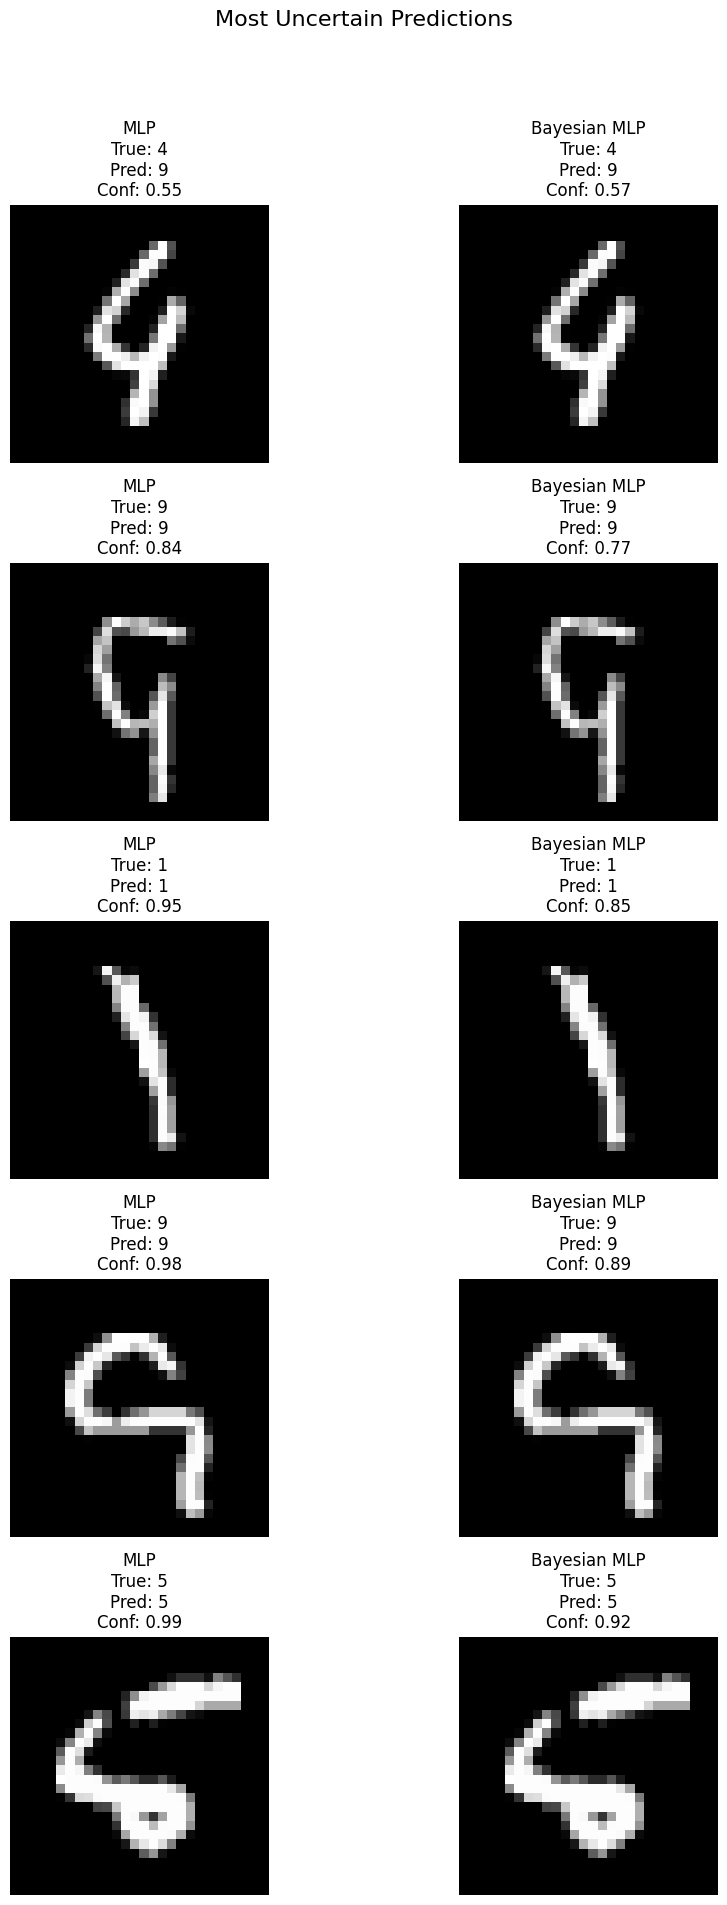

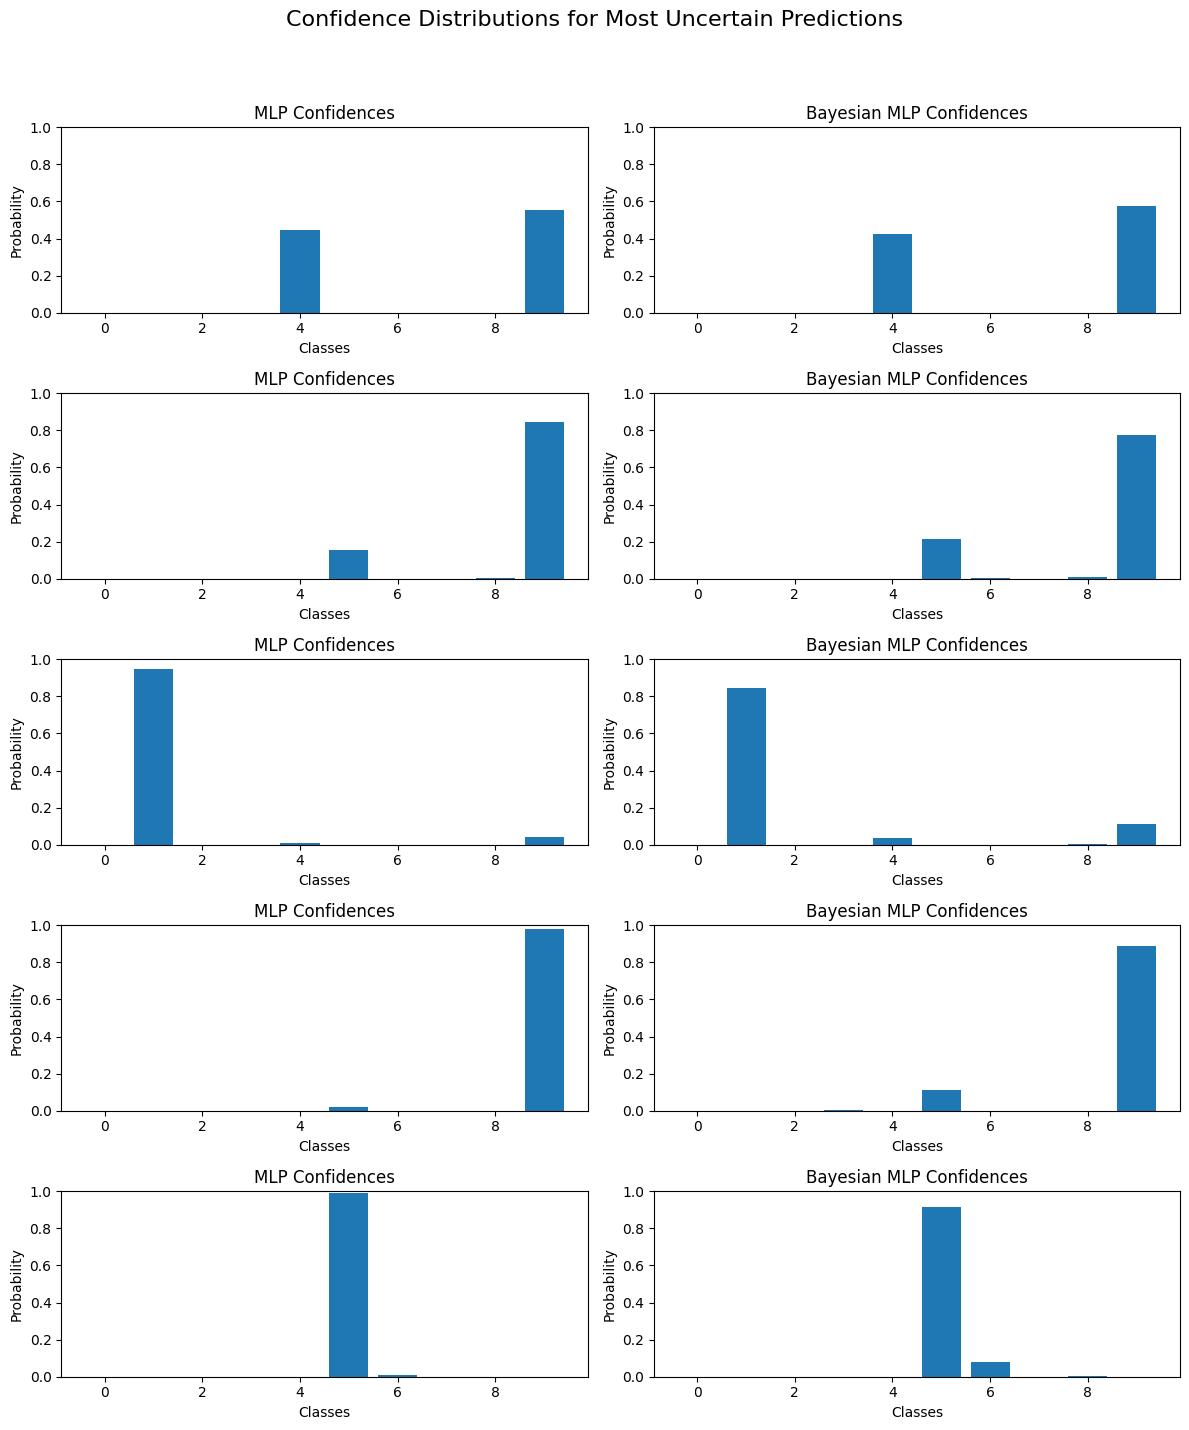


Accuracies for Most Uncertain Predictions:
Regular MLP: 0.8000
Bayesian MLP: 0.8000

Confidence Statistics for Most Uncertain Predictions:
Regular MLP - Mean: 0.8638, Min: 0.5529, Max: 0.9922
Bayesian MLP - Mean: 0.7995, Min: 0.5738, Max: 0.9152


In [32]:
# Plot predictions and confidence distributions for both models
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cpu')

# Get a batch of test data
x_test, y_test = next(iter(test_loader))
x_test = x_test.to(device)
y_test = y_test.to(device)

# Get predictions from both models
bayes_probs = bayes_mlp.predict(x_test)
regular_probs = F.softmax(mlp(x_test), dim=1)

bayes_pred = bayes_probs.argmax(dim=1)
regular_pred = regular_probs.argmax(dim=1)

# Find the most uncertain predictions from Bayesian model
bayes_conf = bayes_probs.max(dim=1)[0]
most_uncertain_idx = torch.argsort(bayes_conf)[:5] # Get indices of 5 lowest confidence predictions

# Create figure for predictions
fig_pred, axes_pred = plt.subplots(5, 2, figsize=(10, 20))
fig_pred.suptitle('Most Uncertain Predictions', fontsize=16)

for i, idx in enumerate(most_uncertain_idx):
    # Plot image
    img = x_test[idx].cpu().squeeze().numpy()
    
    # Regular MLP subplot
    ax = axes_pred[i, 0]
    ax.imshow(img, cmap='gray')
    true_label = y_test[idx].item()
    pred_label = regular_pred[idx].item()
    conf = regular_probs[idx, pred_label].item()
    ax.set_title(f'MLP\nTrue: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
    ax.axis('off')
    
    # Bayesian MLP subplot
    ax = axes_pred[i, 1]
    ax.imshow(img, cmap='gray')
    pred_label = bayes_pred[idx].item()
    conf = bayes_probs[idx, pred_label].item()
    ax.set_title(f'Bayesian MLP\nTrue: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Create figure for confidence distributions of uncertain predictions
fig_conf, axes_conf = plt.subplots(5, 2, figsize=(12, 15))
fig_conf.suptitle('Confidence Distributions for Most Uncertain Predictions', fontsize=16)

for i, idx in enumerate(most_uncertain_idx):
    # Regular MLP confidence distribution
    ax = axes_conf[i, 0]
    ax.bar(range(10), regular_probs[idx].detach().cpu().numpy())
    ax.set_title(f'MLP Confidences')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)
    
    # Bayesian MLP confidence distribution
    ax = axes_conf[i, 1]
    ax.bar(range(10), bayes_probs[idx].detach().cpu().numpy())
    ax.set_title(f'Bayesian MLP Confidences')
    ax.set_xlabel('Classes')
    ax.set_ylabel('Probability')
    ax.set_ylim(0, 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print statistics for uncertain predictions
uncertain_bayes_acc = (bayes_pred[most_uncertain_idx] == y_test[most_uncertain_idx]).float().mean()
uncertain_regular_acc = (regular_pred[most_uncertain_idx] == y_test[most_uncertain_idx]).float().mean()

print(f"\nAccuracies for Most Uncertain Predictions:")
print(f"Regular MLP: {uncertain_regular_acc:.4f}")
print(f"Bayesian MLP: {uncertain_bayes_acc:.4f}")

print(f"\nConfidence Statistics for Most Uncertain Predictions:")
uncertain_regular_conf = regular_probs[most_uncertain_idx].max(dim=1)[0].detach().cpu().numpy()
uncertain_bayes_conf = bayes_probs[most_uncertain_idx].max(dim=1)[0].detach().cpu().numpy()

print("Regular MLP - Mean: {:.4f}, Min: {:.4f}, Max: {:.4f}".format(
    uncertain_regular_conf.mean(), uncertain_regular_conf.min(), uncertain_regular_conf.max()))
print("Bayesian MLP - Mean: {:.4f}, Min: {:.4f}, Max: {:.4f}".format(
    uncertain_bayes_conf.mean(), uncertain_bayes_conf.min(), uncertain_bayes_conf.max()))


Plot reliability diagrams and ECE scores


Calibration Error Scores:
Regular MLP ECE: 0.0064
Bayesian MLP ECE: 0.0120


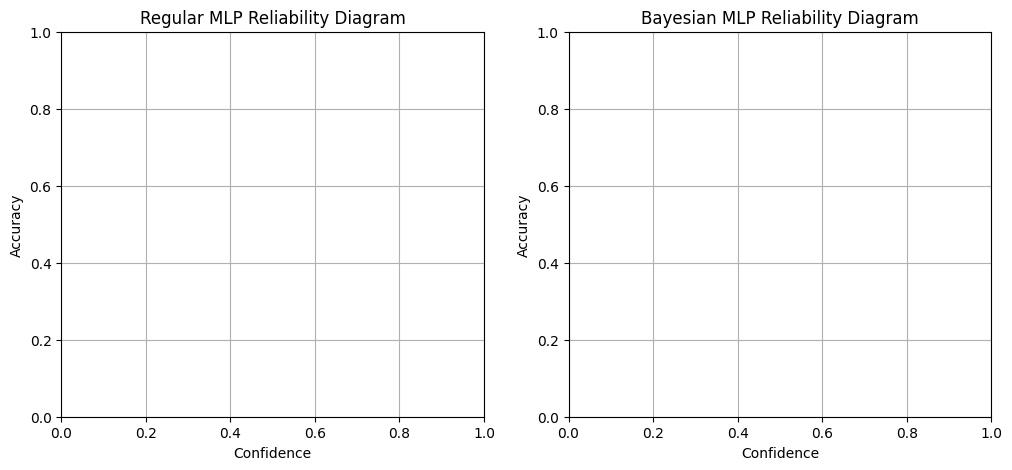

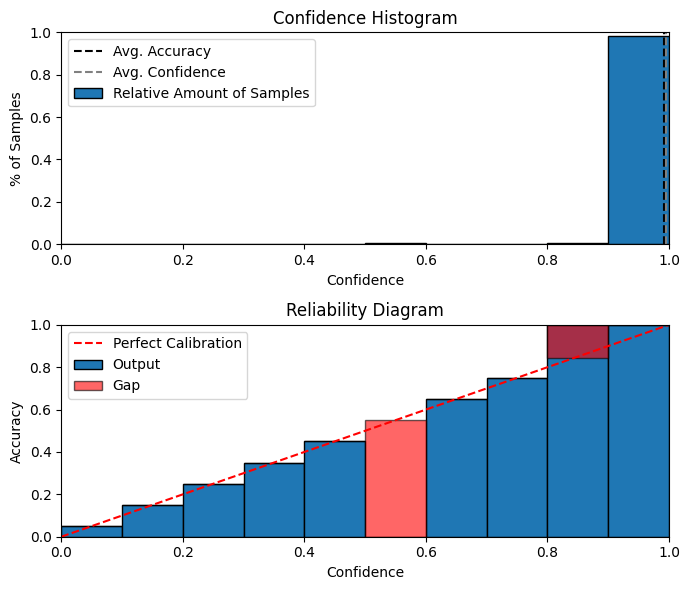

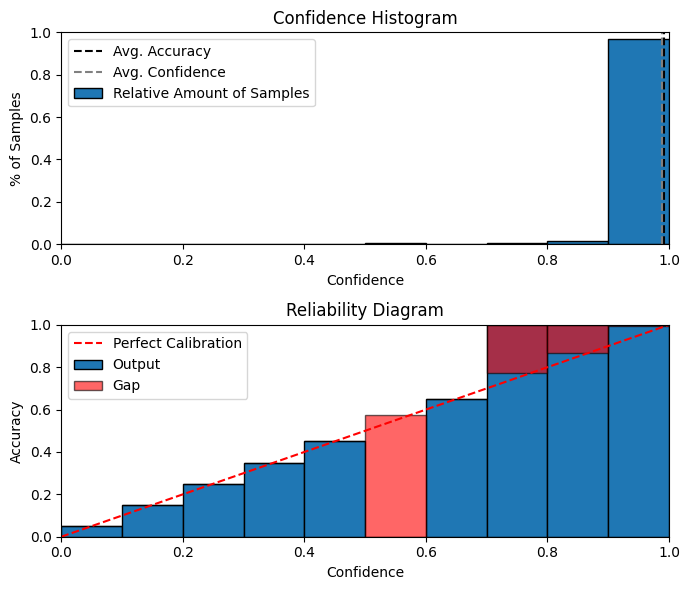

In [33]:
# Evaluate calibration of both models
from netcal.metrics import ECE
from netcal.presentation import ReliabilityDiagram

# Initialize ECE metric and reliability diagram
n_bins = 10
ece = ECE(n_bins)
diagram = ReliabilityDiagram(n_bins)

# Get confidence scores for both models
regular_confidences = regular_probs.detach().cpu().numpy()
bayes_confidences = bayes_probs.detach().cpu().numpy()

y_test_np = y_test.cpu().numpy()

# Calculate ECE scores
regular_ece = ece.measure(regular_confidences, y_test_np) 
bayes_ece = ece.measure(bayes_confidences, y_test_np)

print("\nCalibration Error Scores:")
print(f"Regular MLP ECE: {regular_ece:.4f}")
print(f"Bayesian MLP ECE: {bayes_ece:.4f}")
# Plot reliability diagrams
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Regular MLP reliability diagram
diagram.plot(regular_confidences, y_test_np, ax=ax1)
ax1.set_title('Regular MLP Reliability Diagram')
ax1.grid(True)
ax1.set_xlabel('Confidence')
ax1.set_ylabel('Accuracy')

# Bayesian MLP reliability diagram  
diagram.plot(bayes_confidences, y_test_np, ax=ax2)
ax2.set_title('Bayesian MLP Reliability Diagram')
ax2.grid(True)
ax2.set_xlabel('Confidence')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()


In [26]:
# Save the trained models and Laplace approximation
import torch
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save the Bayesian model and Laplace approximation separately
torch.save(bayes_mlp.base_model.state_dict(), 'models/bayes_mlp.bin')
torch.save(bayes_mlp.la.state_dict(), 'models/laplace.bin')

print("Models and Laplace approximation saved successfully!")

# Example of how to load the models:
"""
# Load regular MLP
mlp2 = MLP()
mlp2.load_state_dict(torch.load('models/regular_mlp.bin'))

# Load Bayesian MLP and Laplace
base_model = MLP() # Create base model first
base_model.load_state_dict(torch.load('models/bayes_mlp.bin'))
bayes_mlp2 = BayesianMLP(base_model) # Initialize with base model
bayes_mlp2.la = Laplace(base_model, 'classification',
                        subset_of_weights='last_layer', 
                        hessian_structure='kron')
bayes_mlp2.la.load_state_dict(torch.load('models/laplace.bin'))
"""


Models and Laplace approximation saved successfully!


"\n# Load regular MLP\nmlp2 = MLP()\nmlp2.load_state_dict(torch.load('models/regular_mlp.bin'))\n\n# Load Bayesian MLP and Laplace\nbase_model = MLP() # Create base model first\nbase_model.load_state_dict(torch.load('models/bayes_mlp.bin'))\nbayes_mlp2 = BayesianMLP(base_model) # Initialize with base model\nbayes_mlp2.la = Laplace(base_model, 'classification',\n                        subset_of_weights='last_layer', \n                        hessian_structure='kron')\nbayes_mlp2.la.load_state_dict(torch.load('models/laplace.bin'))\n"